<a href="https://colab.research.google.com/github/EfanovNikita/EfanovNikita/blob/master/CV_classification_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2B0, EfficientNetB0
from keras import layers, Model, utils, ops
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow import data as tf_data
import cv2

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

!unzip -q "brain-mri-images-for-brain-tumor-detection"

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 872MB/s]


In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128

In [5]:
img_augmentation_layers = [
    layers.RandomTranslation(height_factor=0.3, width_factor=0.3, fill_mode='constant', fill_value=0.0),
    layers.RandomZoom(0.3),
    layers.RandomFlip(),
]

def img_aug(img):
    for layer in img_augmentation_layers:
        img = layer(img)
    return img

In [6]:
DATA_DIR = './brain_tumor_dataset'

for label_dir in os.listdir(DATA_DIR):
    cur_path = os.path.join(DATA_DIR, label_dir)

    for file_name in os.listdir(cur_path):
        file_path = os.path.join(cur_path, file_name)
        img = cv2.imread(file_path)
        img = cv2.resize(img, IMAGE_SIZE)
        aug_img = img_aug(img)
        file_name_and_format = file_name.split('.')
        new_file_name = f"{file_name_and_format[0]}_aug.{file_name_and_format[1]}"
        cv2.imwrite(os.path.join(cur_path, new_file_name), aug_img.numpy())


In [7]:
train_data, val_data = utils.image_dataset_from_directory(
    './brain_tumor_dataset',
    batch_size=16,
    image_size=(224, 224),
    validation_split=0.2,
    subset='both',
    label_mode='binary',
    seed=124
)

class_names = train_data.class_names
print(train_data)
print(val_data)
print(class_names)

Found 506 files belonging to 2 classes.
Using 405 files for training.
Using 101 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
['no', 'yes']


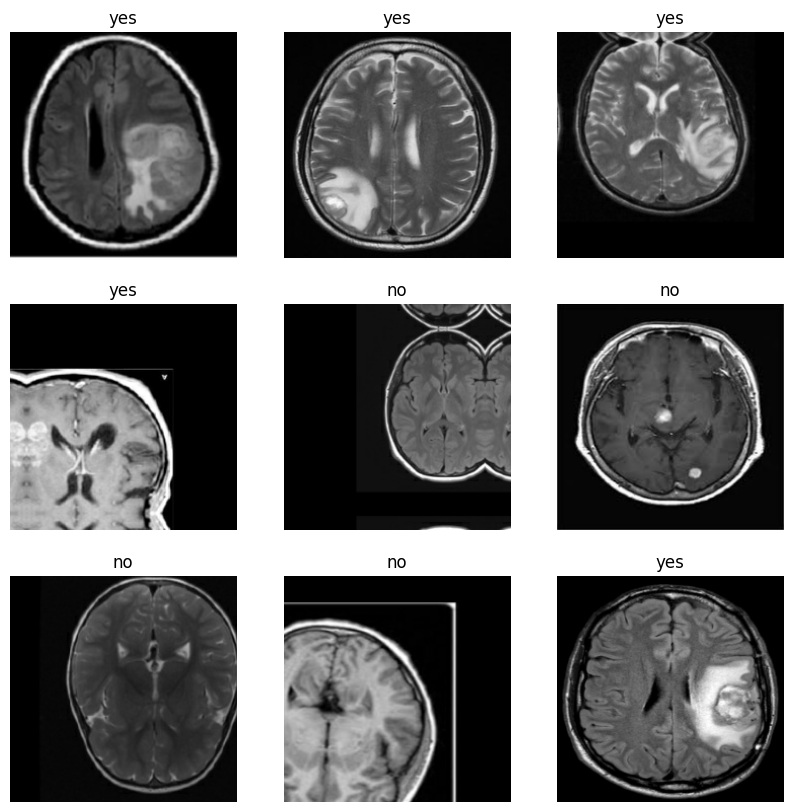

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_data.class_names[labels[i].numpy()[0].astype('uint8')])
    plt.axis("off")

In [9]:
train_data = train_data.prefetch(tf_data.AUTOTUNE)
val_data = val_data.prefetch(tf_data.AUTOTUNE)

In [10]:
def build_model(num_classes):
    input = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2S(include_top=False, input_tensor=input, weights="imagenet")

    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Dense(512, activation='relu')(x)

    x = layers.Dropout(0.5, name="top_dropout")(x)
    output = layers.Dense(1, activation='sigmoid', name = 'pred')(x)

    model = Model(input, output, name="EfficientNetV2")
    optimizer = Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"]
    )

    return model

In [11]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"]
    )

In [12]:
model = build_model(num_classes=len(class_names))
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(train_data, epochs=30, validation_data=val_data, callbacks=[lr_scheduler])

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - acc: 0.5842 - loss: 1.9862 - val_acc: 0.9307 - val_loss: 0.2032 - learning_rate: 0.0100
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.8470 - loss: 0.3782 - val_acc: 0.9109 - val_loss: 0.1889 - learning_rate: 0.0100
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - acc: 0.8494 - loss: 0.4072 - val_acc: 0.9505 - val_loss: 0.1596 - learning_rate: 0.0100
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - acc: 0.8861 - loss: 0.2942 - val_acc: 0.9406 - val_loss: 0.1452 - learning_rate: 0.0100
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.8993 - loss: 0.2516 - val_acc: 0.9604 - val_loss: 0.1290 - learning_rate: 0.0100
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - acc: 0.9247 - loss: 0.2037 - val_acc: 0.9505 - val_loss: 0.1250 - learning_rate: 0.0100
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - acc: 0.9302 - loss: 0.1737 - val_acc: 0.9604 - val_

In [13]:
def show_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, 'b', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'r', label='Точность на проверочной выборке')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'r', label='Потери на проверочной выборке')
    plt.legend()
    plt.figure()

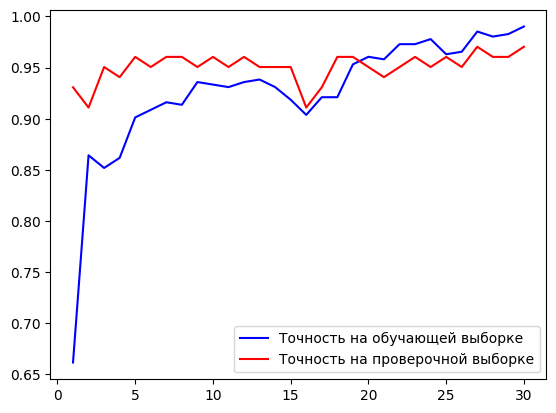

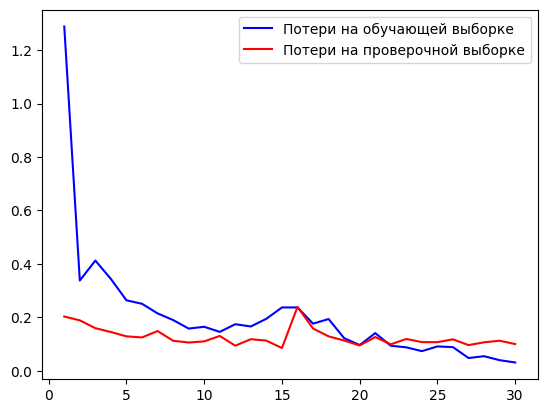

<Figure size 640x480 with 0 Axes>

In [14]:
show_plot(history)

In [15]:
unfreeze_model(model)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(train_data, epochs=30, validation_data=val_data, callbacks=[lr_scheduler])

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - acc: 0.9581 - loss: 0.1828 - val_acc: 0.9208 - val_loss: 0.1814 - learning_rate: 1.0000e-04
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.9614 - loss: 0.1204 - val_acc: 0.9307 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.9841 - loss: 0.0466 - val_acc: 0.9703 - val_loss: 0.1092 - learning_rate: 1.0000e-04
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.9776 - loss: 0.0513 - val_acc: 0.9802 - val_loss: 0.0856 - learning_rate: 1.0000e-04
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - acc: 0.9814 - loss: 0.0489 - val_acc: 0.9505 - val_loss: 0.1356 - learning_rate: 1.0000e-04
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - acc: 0.9816 - loss: 0.0666 - val_acc: 0.9505 - val_loss: 0.1033 - learning_rate: 1.0000e-04
Epoch 7/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.9930 - loss: 0.0218
Epoch 7: ReduceLROnPlateau reducing learning rate t

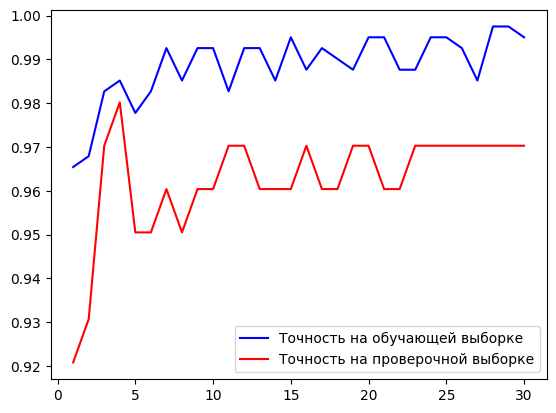

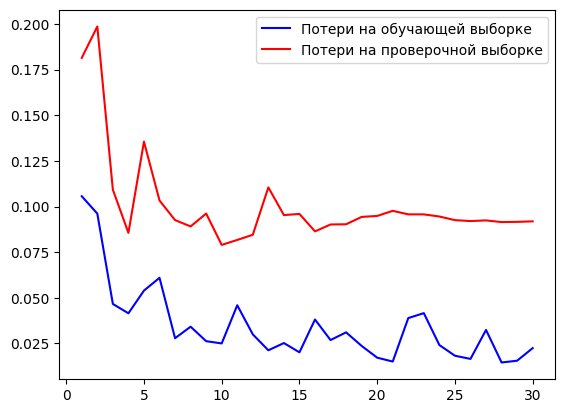

<Figure size 640x480 with 0 Axes>

In [16]:
show_plot(history)